<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/ders_kod/MMI513_week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week 4: Procedural Generation**

Procedural Content Generation (PCG) refers to the creation of content, such as terrain, mazes, trees, and universes, through the use of algorithms and code rather than manual creation. In this notebook, we will explore different PCG methods

## Terrain Generation:
Terrain generation involves creating realistic landscapes such as mountains, hills, and valleys. In this notebook, we will cover different methods to generate natural-looking heightmaps.

## Maze Generation:
Maze generation is the creation of a labyrinthine puzzle through an algorithmic process. In this notebook, we will explore different algorithms to generate a maze, including depth-first search, and Kruskal's method. Prim's method is left as the programming assignment.

## L-Systems:
L-Systems are a type of formal grammar used to model the growth of plants and trees. In this notebook, we will use L-Systems to generate trees by creating a set of rules that determine how the branches and leaves are generated.

# Universe Generation:
Universe generation involves creating a simulation of a fictional universe. In this notebook, we will simulate a universe by creating stars and planets.

- Preamble is where we import the Python modules that we will use

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

plt.rcParams['figure.figsize'] = [7.5, 7.5] # This is to adjust the image size on Jupyter

# Terrain Generation

- We will use different approaches which can possibly be combined at a post-processing stage to generate more interesting terrains.

## Simple Random Terrain

- Simple random terrain is simple but not interesting.
- It has many high-frequency features that makes it look just too noisy.
- It is simple to generate but not of much use.

In [ ]:
def simplerandomterrain(H=np.zeros((100,100)), hmax=10.):
    rw, col = np.shape(H)
    for ind in range(rw):
        for jnd in range(col):
            H[ind, jnd] = np.random.rand() * hmax
    return H

## **Testing Code** ✅

Text(0.5, 1.0, 'Simple Random Terrain')

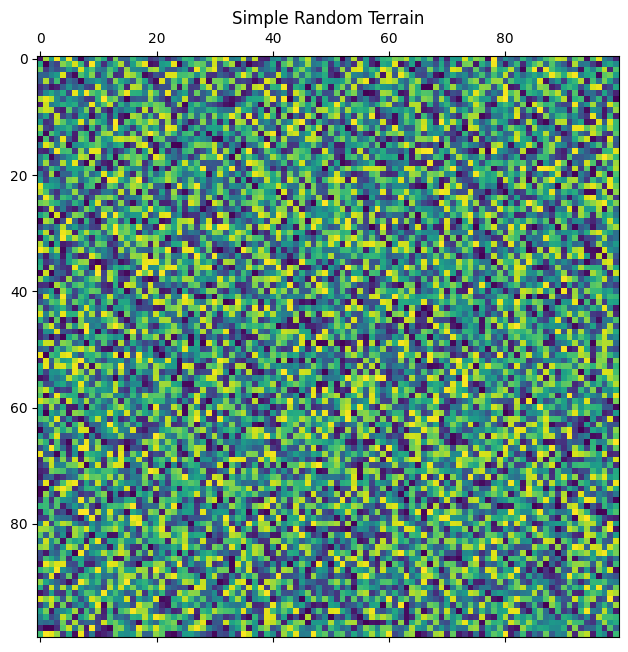

In [ ]:
H = simplerandomterrain()
plt.matshow(H, cmap='viridis', interpolation='none')
plt.title('Simple Random Terrain')

### Limited Random Terrain

- In limited random terrain the generated terrain propagates as a moving average across grid elements
- This allows interesting patterns to be generated.

In [ ]:
def limitedrandomterrain(H=np.zeros((100,100)), hmax=1., dmax=0.02):
    rw, col = np.shape(H)
    for ind in range(rw):
        for jnd in range(col):
            if (ind, jnd) != (0,0):
                avg = (H[ind-1, jnd] + H[ind, jnd-1])/2.
            elif (ind!=0) & (jnd==0):
                avg = H[ind-1, jnd]
            else:
                avg = np.random.rand() * hmax
            h = avg + dmax * (np.random.rand() - 0.5)
            H[ind, jnd] = max(0., min(h, hmax))
    return H

## **Testing Code** ✅

Text(0.5, 1.0, 'Limited Random Terrain')

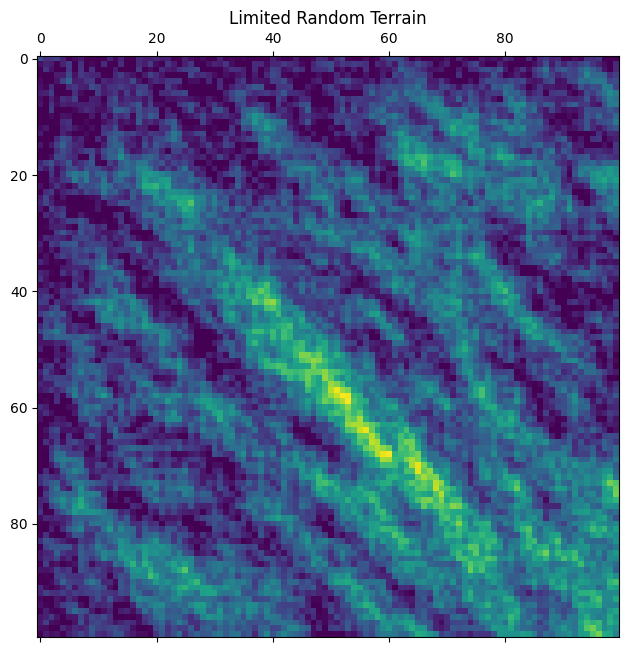

In [ ]:
H = limitedrandomterrain(dmax = 0.2)
plt.matshow(H, cmap='viridis', interpolation='none')
plt.title('Limited Random Terrain')

# Particle Deposition Terrain

- Particle deposition adds sediment to cells
- When a certain threshold is reached the added sediment is transferred to neighbours.
- We use Brownian motion in `brownianmovement()` to select the next cell to deposit sediment
- We check the difference in the number of particles in a given cell using `unbalancedneighbour()`

In [ ]:
def neighbour(H, p, nflag):
    rw, cl = np.shape(H)
    if nflag=='E':
        if p[1] >= cl - 1:
            return (p[0], 0)
        else:
            return (p[0], p[1] + 1)
    elif nflag=='W':
        if p[1] <= 0:
            return (p[0], cl - 1)
        else:
            return (p[0], p[1] - 1)
    elif nflag=='N':
        if p[0] <= 0:
            return (rw - 1, p[1])
        else:
            return (p[0] - 1, p[1])
    elif nflag=='S':
        if p[0] >= rw - 1:
            return (0, p[1])
        else:
            return (p[0]+1, p[1])
    else:
        raise ValueError('nflag can be \'E\', \'W\', \'N\', \'S\' only')

def unbalancedneighbour(H, p, ip, b = 4):
    rw , cl = H.shape
    e = neighbour(H, p, 'E')
    w = neighbour(H, p, 'W')
    n = neighbour(H, p, 'N')
    s = neighbour(H, p, 'S')

    if H[p] + ip - H[e] > b:
        return e
    if H[p] + ip - H[w] > b:
        return w
    if H[p] + ip - H[n] > b:
        return n
    if H[p] + ip - H[s] > b:
        return s
    return None

def brownianmovement(H, p):
    rnd = np.random.randint(0, 4)
    if rnd==0:
        return neighbour(H, p, 'E')
    elif rnd==1:
        return neighbour(H, p, 'W')
    elif rnd==2:
        return neighbour(H, p, 'N')
    else:
        return neighbour(H, p, 'S')

def increase(H, p, increase=0.1, hmax=10.):
    ip = min(hmax-H[p], increase)
    n = unbalancedneighbour(H, p, ip)
    if n==None:
        return p, ip
    else:
        return increase(H, p, increase, hmax)

def particledepositionterrain(m, rw, cl):
    H = np.zeros((rw, cl))
    p = (np.random.randint(0, rw), np.random.randint(0, cl))
    for ind in range(m):
        pp, ip = increase(H, p)
        H[pp] = H[pp] + ip
        p = brownianmovement(H, p)
    return H

## **Testing Code** ✅

Text(0.5, 1.0, 'Particle Deposition Terrain')

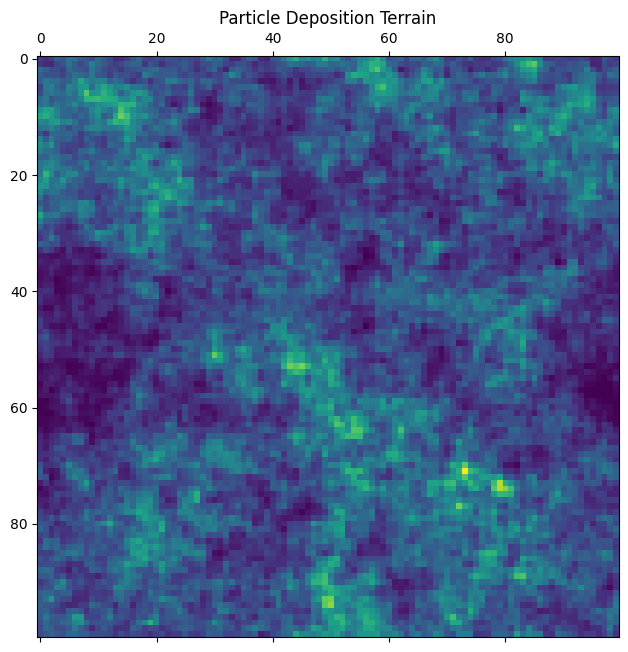

In [ ]:
H = particledepositionterrain(200000, 100, 100)
plt.matshow(H, cmap='viridis', interpolation='none')
plt.title('Particle Deposition Terrain')

# Fault Line Terrain

- We will generate fault lines that will be the defining property of the terrain we create.
- We set the number of fault lines to be generated as `f` and a threshold as `c`

In [ ]:
def levelterrain(rw, cl, hmax):
    H = np.ones((rw, cl)) * hmax / 2.
    return H

def faultlineterrain(rw=100, cl=100, hmax=100, f=1000, c=2):
    H = levelterrain(rw, cl, hmax)
    x = np.arange(cl)
    y = np.arange(rw)
    xx, yy = np.meshgrid(x, y)

    for ind in range(f):
      x0 = np.random.randint(0, cl - 1)
      x1 = np.random.randint(0, cl - 1)
      y0 = np.random.randint(0, rw - 1)
      y1 = np.random.randint(0, rw - 1)
      v = np.array([x0-x1, y0-y1])
      for xind in range(cl):
        for yind in range(rw):
          wv = np.array([xx[xind, yind], yy[xind, yind]])
          cz = (x1 - x0) * (yy[xind, yind] - y0) - (y1 - y0) * (xx[xind, yind] - x0)
          if cz > 0:
            H[xind, yind] = np.min([H[xind, yind] + c, hmax])
          else:
            H[xind, yind] = np.max([H[xind, yind] - c, 0.])
    return H

## **Testing Code** ✅

- Fault-line terrain takes a little too long to generate

Text(0.5, 1.0, 'Fault Line Terrain')

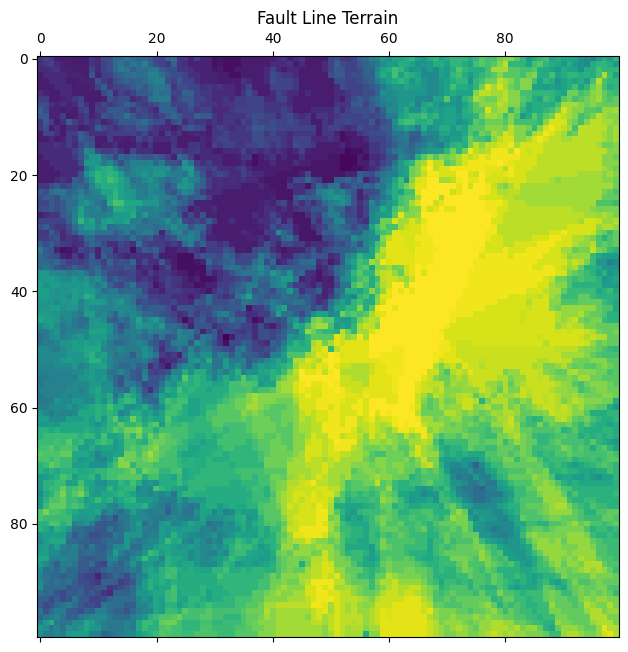

In [ ]:
H = faultlineterrain(f=1000)
plt.matshow(H, cmap='viridis', interpolation='none')
plt.title('Fault Line Terrain')

# Circle Hill Terrain

- We create mini circular hills in the terrain using a cosine function

In [ ]:
def circlehillterrain(rw=100, cl=100, c=500, r = 10, s=4, hmax = 64):
  H = np.zeros((rw, cl))
  x = np.arange(cl)
  y = np.arange(rw)
  xx, yy = np.meshgrid(x, y)
  r2 = r ** 2
  for cind in range(c):
    xp = np.random.randint(0, cl - 1)
    yp = np.random.randint(0, rw - 1)
    for xind in range(cl):
      for yind in range(rw):
        x = xx[xind, yind]
        y = yy[xind, yind]
        d2 = (xp - x) ** 2 + (yp - y) ** 2
        if d2 < r2:
          a = (s / 2) * (1 + np.cos(np.pi * d2 / r2))
          H[xind, yind] = np.min([H[xind, yind] + a, hmax])
  return H

## **Testing Code** ✅

Text(0.5, 1.0, 'Circle Hill Terrain')

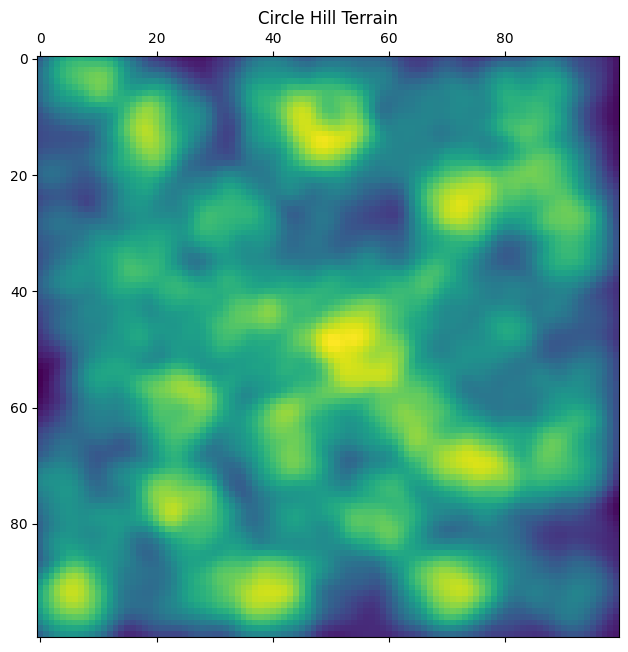

In [ ]:
H = circlehillterrain()
plt.matshow(H, cmap='viridis', interpolation='none')
plt.title('Circle Hill Terrain')

# Midpoint Displacement Terrain

In [ ]:
def displacement(H, x: int, y: int, Stup, d):
  out = 0
  avg = 0
  for ind in range(4):
    # print(int(x) + int(Stup[2 * ind]), int(y) + int(Stup[2 * ind + 1]))
    avg += 0.25 * H[int(x) + int(Stup[2 * ind]), int(y) + int(Stup[2 * ind + 1])]
  out = d + avg
  return out

def midpointterrain(k=8, dmax=128, s=1.5):
  n = 2 ** k + 1
  H = np.zeros((n, n))
  rnds = np.random.rand(4) * dmax
  H[0,0], H[0, n - 1], H[n-1,0], H[n-1, n-1] = rnds[0], rnds[1], rnds[2], rnds[3]
  m = n - 1
  c = 1
  d = dmax
  while m >= 2:
    w = int(m / 2)
    x = int(w)
    for ind in range(c): # Centres
      y = int(w)
      for jnd in range(c):
        H[int(x), int(y)] = displacement(H, x, y, (-w, -w, -w, w, w, -w, w, w), d)
        y += m
      x += m
    x -= w
    t = int(w)
    for p in range(c): # Borders
      H[0, int(t)] = displacement(H, 0, t, (0, -w, 0, w, w, 0, w, 0), d)
      H[int(t), 0] = displacement(H, t, 0, (-w, 0, w, 0, 0, w, 0, w), d)
      H[int(t), int(x)] = displacement(H, t, x, (-w, 0, w, 0, 0, -w, 0, -w), d)
      H[int(x), int(t)] = displacement(H, x, t, (0, -w, 0, w, -w, 0, -w, 0), d)
      t += m

    x = m
    for ind in range(c-1): # Middle horizontal
      y = w
      for jnd in range(c):
        H[int(x),int(y)] = displacement(H, x, y, (-w, 0, w, 0, 0, -w, 0, w), d)
        y += m
      x += m

    x = w
    for ind in range(c): # Middle vertical
      y = m
      for jnd in range(c-1):
        H[int(x),int(y)] = displacement(H, x, y, (-w, 0, w, 0, 0, -w, 0, w), d)
        y += m
      x += m

    m /= 2
    c *= 2
    d *= 2**(-s)
  return H

## **Testing Code** ✅

- We will test with default arguments but you can try and see the effects of changing these arguments

Text(0.5, 1.0, 'Midpoint Displacement Terrain')

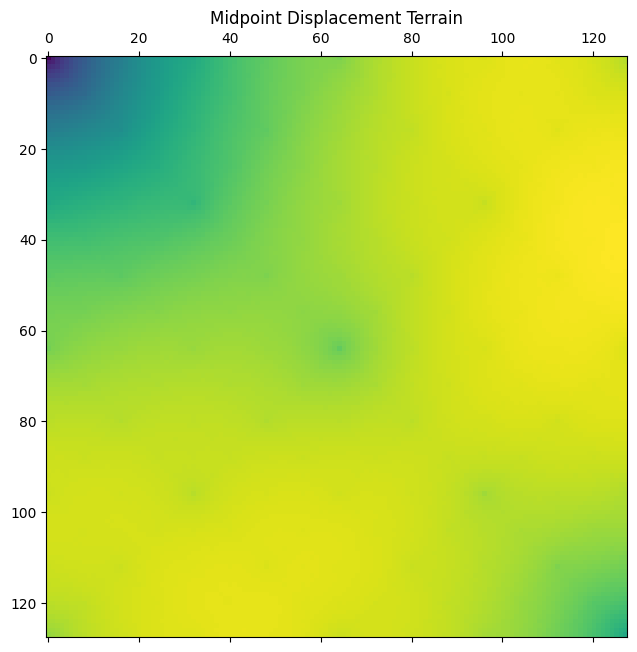

In [ ]:
H = midpointterrain()
plt.matshow(H[0:128, 0:128], cmap='viridis', interpolation='none')
plt.title('Midpoint Displacement Terrain')

# Mazes

- We will now consider two different mazes: depth-first maze and Kruskal's maze. Pimm's maze is left as the programming assignment (see below)

## Unidirected Graph

- We will first generate an undirected graph for use with the maze algorithms that we will design.
- This is the starting point and template for the maze generation methods

In [ ]:
  def undirectedconnectiongraph(xnum=30, ynum=30):
    G = {'V':[], 'E':[]} # We will use a dictionary for simplicity
    for xind in range(xnum):
      for yind in range(ynum):
        G['V'].append((xind, yind))

    # Traverse north first
    for pt in G['V']:
      vtn = north(pt[0], pt[1])
      if isvertex(vtn, G['V']):
        G['E'].append((pt, vtn))

    # Traverse east second
    for pt in G['V']:
      vte = east(pt[0], pt[1])
      if isvertex(vte, G['V']):
        G['E'].append((pt, vte))
    return G

  def north(xind, yind):
    node = (xind, yind + 1)
    return node

  def south(xind, yind):
    node = (xind, yind - 1)
    return node

  def east(xind, yind):
    node = (xind + 1, yind)
    return node

  def west(xind, yind):
    node = (xind - 1, yind)
    return node

  def isvertex(node, vertices):
    return node in vertices

  def plotgraph(G, vertexflag=True):
    for e in G['E']:
      vec = np.array([e[1][0]-e[0][0], e[1][1]-e[0][1]])
      ort = np.array([-vec[1], vec[0]])
      olen = np.linalg.norm(ort)
      ort = ort / olen
      sum = np.array([(e[1][0]+e[0][0])/2, (e[1][1]+e[0][1])/2])
      startp = sum - ort / 2
      endp = sum + ort / 2
      plt.plot((startp[0], endp[0]), (startp[1], endp[1]), 'k', linewidth=10)
      if vertexflag:
        for v in G['V']:
          plt.plot(float(v[0]), float(v[1]), 'ro')
    plt.axis('square')
    plt.show()

  def neighbourhood(node, vertices):
    pneighbours = [north(node[0], node[1]), south(node[0], node[1]), east(node[0], node[1]), west(node[0], node[1])]
    neighbours = []
    for ind in range(len(pneighbours)):
      n = pneighbours[ind]
      if(isvertex(n, vertices) == True):
        neighbours.append(n)
    return set(neighbours)

  def randomnode(vertices):
    vertices = list(vertices)
    randind = np.random.randint(0, len(vertices))
    return vertices[randind]

  def subsetinset(query, settosearch): # Used also in Kruskal's method
    subset = set()
    for element in settosearch:
        if len(query.difference(element))==0:
          subset = subset.union(set(element))
    return frozenset(subset)

  def frozenunion(S1, S2):
    Sunion = set()
    for element in S1:
      Sunion = Sunion.union(set([element]))
    for element in S2:
      Sunion = Sunion.union(set([element]))
    return frozenset(Sunion)

## **Testing Code** ✅

KeyboardInterrupt: ignored

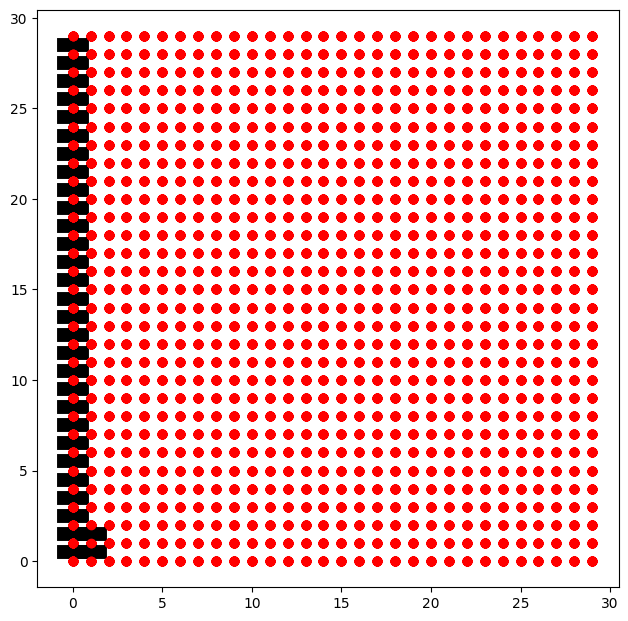

In [ ]:
G = undirectedconnectiongraph(30, 30)
plotgraph(G, False)

In [ ]:
neig = neighbourhood((1,1), G['V'])
node = randomnode(neig)
print(node)

(1, 0)


## Depth-first maze

- Depth-first maze accepts a unidirected graph $G$ and outputs a maze
- You will see that the DF maze has very long paths.

In [ ]:
def depthfirstmaze(G):
  vertices = G['V'].copy()
  C = set(G['V'].copy()) # Unvisited cells
  W = set(G['E'].copy()) # Walls
  S = [] # We will use a list as a substitute for a stack
  c = randomnode(C) # We will visit this node first
  C.remove(c) # Remove visited
  flag = True
  while flag:
    neigset = neighbourhood(c, vertices) # Find all neighbours
    N = neigset.intersection(C) # Select only the (as yet) unvisited neighbours
    if len(N)==0: # All neighbours already visited, select another starting point
      if len(S) >= 1:
        c = S.pop()
    else:
      n = randomnode(N)

      try: # We are using sets that are not ordered.
        W.remove((c,n))
      except:
        W.remove((n,c))

      S.append(c) # Add c to stack storing already visited cells
      c = n
      C.remove(n)
    flag = (len(C) > 0)

  M = dict()
  M['V'] = G['V'].copy()
  M['E'] = list(W)
  return M

## **Testing Code** ✅

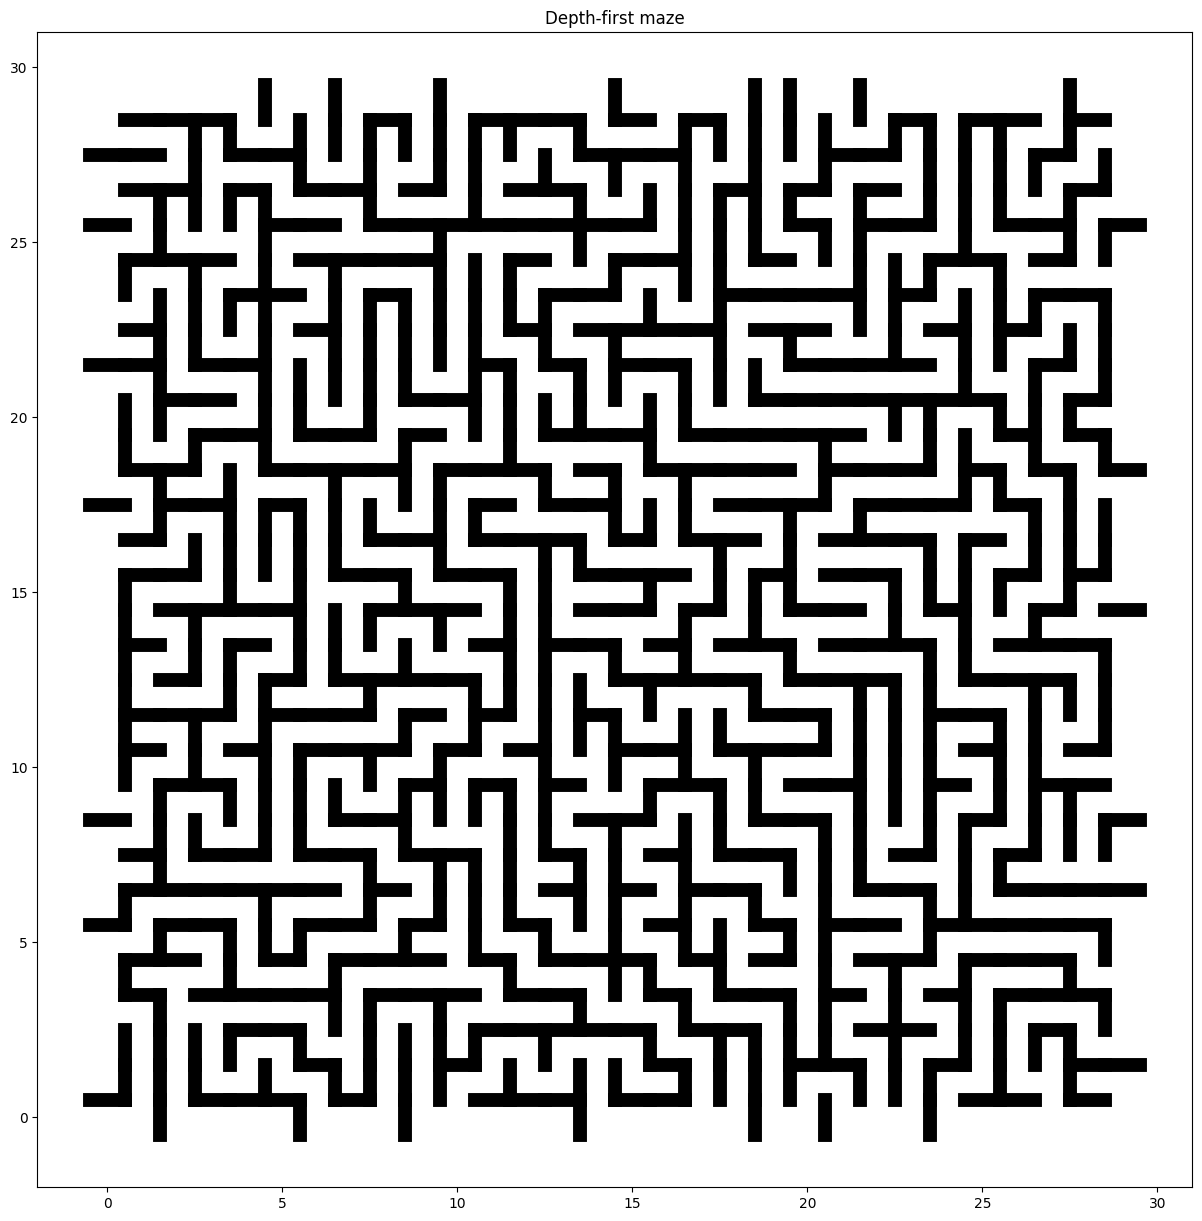

In [ ]:
M = depthfirstmaze(G)
plt.title('Depth-first maze')
plt.rcParams['figure.figsize'] = [15, 15] # This is to adjust the image size on Jupyter
plotgraph(M, False)

## Kruskal Maze

- Kruskal maze provides a slightly different maze structure. Notice the differences in the maze pattern.
- The way it is generated is also different.

In [ ]:
def kruskalmaze(G):
  vertices = G['V'].copy()
  W = set(G['E'].copy())
  M = set()

  for node in vertices: # Initially all cells are isolated
    M.add(frozenset([node])) # Set of sets Read about mutability in Python!

  for wall in W.copy(): # Set size over the iterator cannot change during the iteration!
    c1 = frozenset([wall[0]])
    c2 = frozenset([wall[1]])
    S1 = subsetinset(c1, M)
    S2 = subsetinset(c2, M)
    if (S1 != S2):
      W.remove(wall)
      M.remove(S1)
      M.remove(S2)
      Sunion = frozenunion(S1, S2)
      M.add(Sunion)
  M = dict()
  M['V'] = G['V'].copy()
  M['E'] = list(W)
  return M

## **Testing Code** ✅

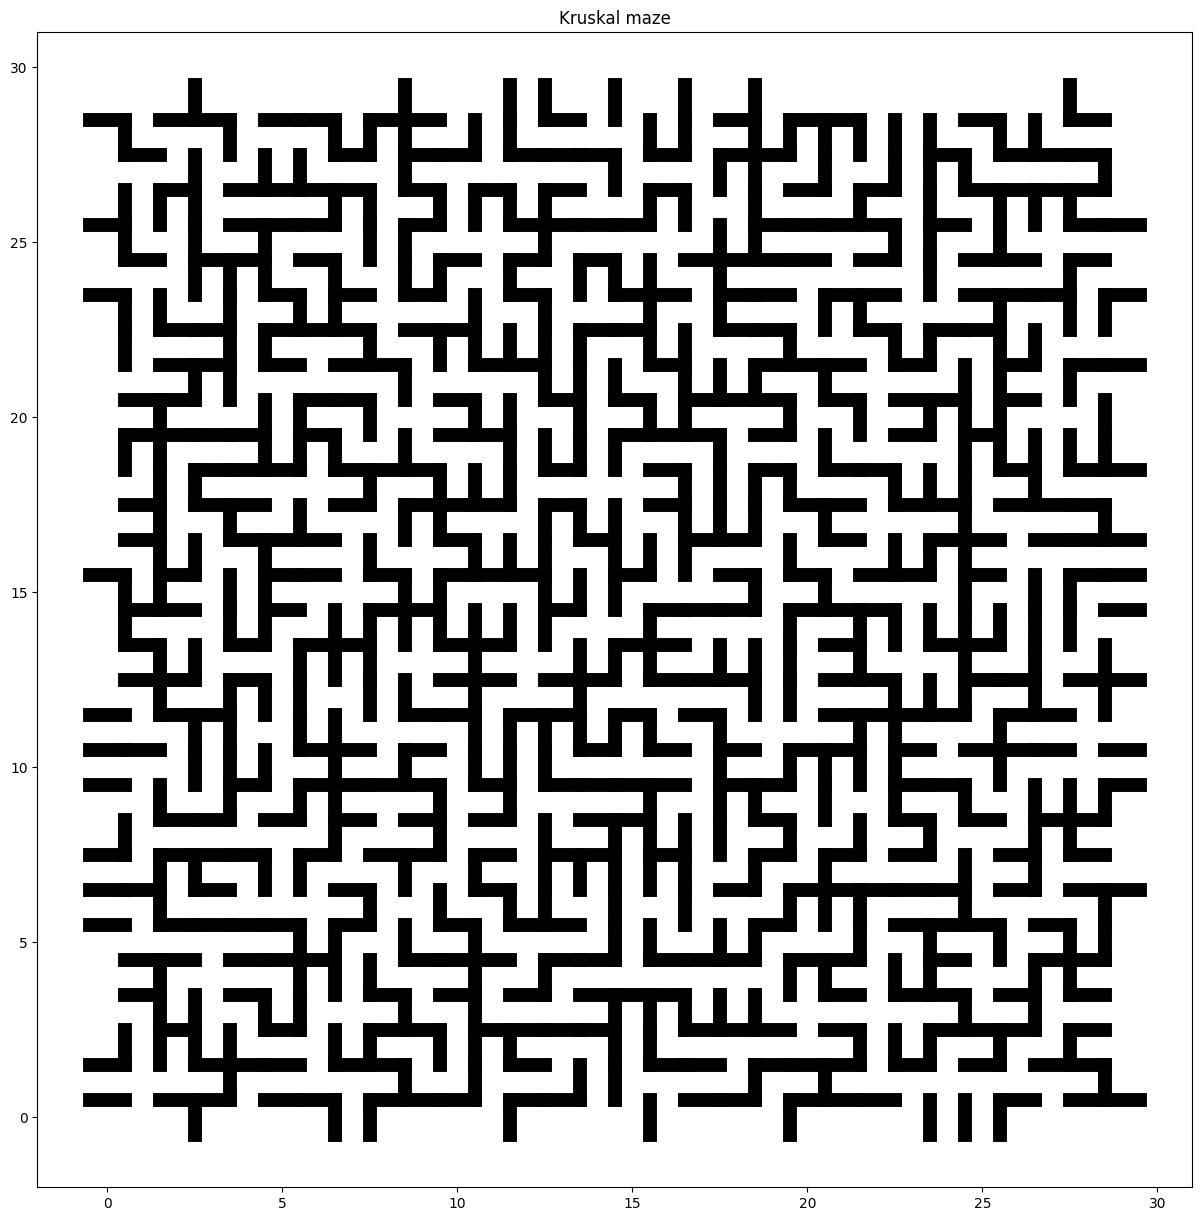

In [ ]:
M = kruskalmaze(G)
plt.title('Kruskal maze')
plt.rcParams['figure.figsize'] = [15, 15] # This is to adjust the image size on Jupyter
plotgraph(M, False)

# L-Systems

- We will see two different L-systems which can be expressed using a very limited set of rules.
- The first L-system is Fibonacci words which we will visualise using a movement paradigm.

## Fibonacci Words

- The rules for generating a Fibonacci words is easy and compact.
- We have the dictionary which comprises $0$ and $1$
- The axiom is $1$
- The rule involves substituting $10$ for $1$ and $1$ for $0$

$$\left\{\begin{array}[c]\ V=\{0,1\}\\\omega=1\\P=\{(0\rightarrow{}1), (1\rightarrow{}10)\}\end{array}\right.$$

- We implement the two rules as two different functions: `fiborule1` and `fiborule2`
- We iteratively apply the fules to the original axiom which gets larger and larger.

In [ ]:
def fibonacciwords(axiomstr, ruleset, numiter=3):
  out = ''
  state = axiomstr
  for ind in range(numiter):
    out = ''
    for ch in state:
      for rule in ruleset:
         out += rule(ch)
    state = out
  if numiter == 0:
    return axiomstr
  return out

def fiborule1(inputchar):
  outputchar = ''
  if inputchar == '0':
    outputchar = '1'
  return outputchar


def fiborule2(inputchar):
  outputchar = ''
  if inputchar == '1':
    outputchar = '10'
  return outputchar


In [ ]:
ruleset = {fiborule1, fiborule2}
for ind in range(9):
  output = fibonacciwords('1', ruleset, ind)
  print('S' + str(ind) + ': ', output)

S0:  1
S1:  10
S2:  101
S3:  10110
S4:  10110101
S5:  1011010110110
S6:  101101011011010110101
S7:  1011010110110101101011011010110110
S8:  1011010110110101101011011010110110101101011011010110101


- In order to visualise we will use `turnright` and `turnleft` functions

In [ ]:
def turnright(direction):
  if direction == (1, 0):
    mvec = (0, -1)
  elif direction == (-1, 0):
    mvec = (0, 1)
  elif direction == (0, 1):
    mvec = (1, 0)
  elif direction == (0, -1):
    mvec = (-1, 0)
  else:
    raise ValueError('Direction is wrong!')

  nextdir = mvec

  return nextdir

def turnleft(direction):
  if direction == (1, 0):
    mvec = (0, 1)
  elif direction == (-1, 0):
    mvec = (0, -1)
  elif direction == (0, 1):
    mvec = (-1, 0)
  elif direction == (0, -1):
    mvec = (1, 0)
  else:
    raise ValueError('Direction is wrong!')
  nextdir = mvec
  return nextdir

def drawsequence(inputstr):
  point1 = (0, 0)
  direction = (0, 1)
  inputlist = list(inputstr)
  for ind in range(len(inputlist)):
    if inputlist[ind] == '1':
      if ((ind % 2) == 0):
        direction = turnright(direction)
      elif ((ind % 2) == 1):
        direction = turnleft(direction)
    point2 = tuple(np.array(point1) + np.array(direction))
    plt.plot((point1[0], point2[0]), (point1[1], point2[1]), 'b')
    point1 = point2
  plt.axis('off')
  plt.axis('square')
  plt.show()
  pass

## **Testing Code** ✅

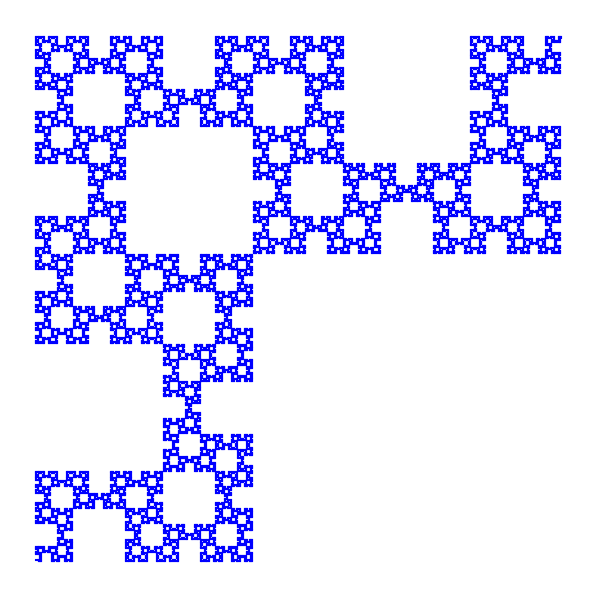

In [ ]:
output = fibonacciwords('1', ruleset, 20)
plt.rcParams['figure.figsize'] = [7.5, 7.5]
drawsequence(output)

## Plant generation with L-systems

- You will see that the generating code for the L-system for the plant model is different from that for Fibonacci words but implements the same idea in a somewhat simpler way!

In [ ]:
def plantrule1(inputstr):
  outputstr = inputstr.replace('f', 'ff')
  return outputstr

def plantrule2(inputstr):
  outputstr = inputstr.replace('x', 'f[+f]f[-x]+x')
  return outputstr

def plantword(axiomstr, rulelist, numiter=3):
  state = axiomstr
  rulelen = len(rulelist)
  for ind in range(numiter):
    for jnd in range(rulelen):
      state = rulelist[jnd](state)
  if numiter == 0:
    return axiomstr
  return state

def rotmat(theta=0):
  mat = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
  return mat

def plantplot(plantstr, rotdeg = 25.):

  position = np.array([0.,0.]).reshape((2,1))
  direction = np.array([0.,1.]).reshape((2,1))
  rootpos = position.copy()
  state = (position, direction)
  stack = []

  radrot = np.deg2rad(rotdeg)
  rmatplus = rotmat(radrot)
  rmatminus = rotmat(-radrot)

  ln = len(plantstr)
  outroots = []

  for ind in range(ln):
    ch = plantstr[ind]
    # [HH note, 18.08.2022] We will use a bothersome if...elif...else. In
    #                       Python 3.10 we can replace this by a match...case
    if ch == 'f': # move one step
      position = position.copy() + direction
    elif ch == '[': # draw the branch and push the current position to stack
      plt.plot((rootpos[0], position[0]), (rootpos[1], position[1]), 'b')
      state = (position.copy(), direction.copy())
      stack.append(state)
      # rootpos = position.copy()
    elif ch == '+': # rotate the direction vector by rotang
      direction = rmatplus @ direction
    elif ch == '-': # rotate the direction vector by -rotang
      direction = rmatminus @ direction
    elif ch == ']': #
      state = stack.pop()
      position = state[0].copy()
      direction = state[1].copy()
      rootpos = position.copy()
    elif ch == 'x':
      state = (position.copy(), direction.copy())
      outroots.append(state)
  plt.axis('off')
  plt.axis('square')
  plt.show()
  pass

## **Testing Code** ✅


ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff[+ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff]ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff[-ffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff[+fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff

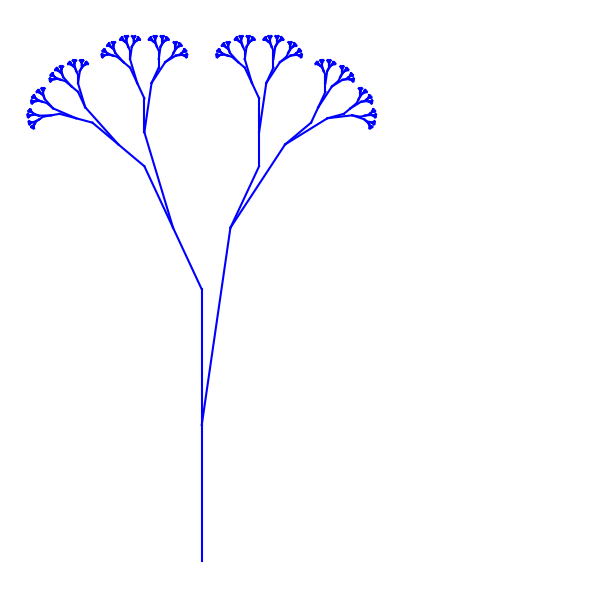

In [ ]:
axiom = 'x'
ruleset = [plantrule1, plantrule2]
plstr = plantword(axiom, ruleset, numiter=9)
print(plstr)

rootpos = np.array([0.,0.]).reshape((2,1))
plantplot(plstr)


# Hierarchical Universe Generation

- Generating stars and planets is a fairly east task which involves generating random numbers.
- We will not be bothered with name generation. There is a link provided below for a Python module which does just that.

In [ ]:
def createstars(nuseed, xmax, ymax, density):
  try:
    assert 0<=density<=1
  except:
    raise ValueError('Density cannot be less than 0 or larger than 1')
  G = dict() # Our implementation will be slightly different with a dictionary and not a matrix
  np.random.seed(nuseed)
  for x in range(xmax):
    for y in range(ymax):
      if np.random.rand() < density:
        G[(x, y)] = np.random.randint(0, 2**32-1)
  return G

def createplanets(nuseed, pmin, pmax):
  np.random.seed(nuseed)
  p = np.random.randint(pmin, pmax)
  P = []
  for ind in range(p):
    P.append(np.random.randint(0, 2**32-1))
  return P

## **Testing Code** ✅

In [ ]:
G = createstars(31245, 50, 50, 0.02)
P = createplanets(31245, 4, 20)

A good random star name generator is here: https://github.com/borogove/names

# Programming Assignment #3

## **Fall 2023/24 Semester**

- Implement Randomized Prim maze using the undirected connection graph **on this notebook**.
_ You can use the pseudocode in the textbook (p. 94 of 2017 ed.)

**!!! IMPORTANT !!!**: If your implementation does not use the `undirectedconnectiongraph` and `plotgraph` functions in this notebook your grade for this assignment will be zero.

**GRADING:**

1. `pimmsmaze()` function works with default arguments (60/100)
2. Code carries out necessary checks on inputs via proper assertions (20/100)
3. Code is properly commented, explained and documented (20/100)

**Notes:**
1. You are free to use chatGPT for help. However, you should not use code generated by chatGPT directly and you should mention which part of the code is chatGPT in the comments. Your code will be checked for verbatim copying from chatGPT.
2. You are not allowed to use external modules/libraries in your implementations except those already in the notebook, but you can use them for testing your code.
3. You will upload your submission as a Python notebook to ODTUClass.

(c) Huseyin Hacihabiboglu, 2022-2023